Student Details

Name: Vipul Popat

ID: 18195121

# Lab 5: Feature Selection 

This notebook builds on top of Lab 4 by introducing feature selection into the process of selecting the best classifier for a binary classification problem.

The feature selection method applied here is Recursive Feature Elimination (RFE) as demonstrated in the tutorial at https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/.

In this demonstration we use a modified version of the seeds data set (see https://archive.ics.uci.edu/ml/datasets/seeds), which is the same data set used in Lab 4.

## A. Preparation

### Import Python modules

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,chi2

# for reproducible results
np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')


# Task 1

  * Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv and draw initial conclusions from the results you observe.

In [2]:
df = pd.read_csv("./winequality_red.csv")
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [3]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.shape

(1599, 12)

In [5]:
# target attribute
target_attribute_name = 'quality'
target = df[target_attribute_name]

# predictor attributes
predictors = df.drop(target_attribute_name, axis=1).values

In [6]:
# Check the target variables unique values
target.unique()

array([5, 6, 7, 4, 8, 3])

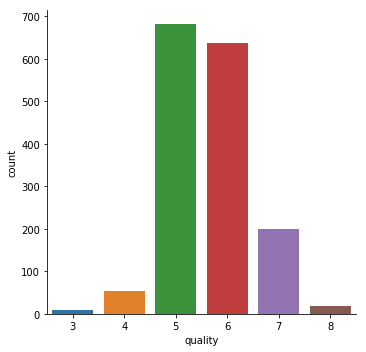

In [7]:
# show the number of observations in each target category
sns.catplot(x="quality", kind="count", data=df);

Split the data set into a training (80%) and test (20%) data sets.

In [8]:
# pepare independent stratified data sets for training and test of the final model
predictors_train, predictors_test, target_train, target_test = train_test_split(
    predictors, target, test_size=0.20, shuffle=True, stratify=target)

In [9]:
# scale all predictor values to the range [0, 1]
min_max_scaler = preprocessing.MinMaxScaler()

# The scaler is being applied to dataset after the dataset is split into
# training and test to avoid data snooping
min_max_scaler.fit(predictors_train)

# Scaling the train data set
predictors_train = min_max_scaler.transform(predictors_train)

# Scaling the test set using the transform defined by the train set.
predictors_test = min_max_scaler.transform(predictors_test)

## B. Feature Selection

#### 1. Apply RFE with SVM for selecting the best features

In [10]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVM = svm.SVR(kernel="linear")
selectorSVM = RFE(estimatorSVM, 3)
selectorSVM = selectorSVM.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorSVM.support_)
print(selectorSVM.ranking_)

[False  True False False False False False False False  True  True]
[4 1 9 5 3 8 2 6 7 1 1]


In [11]:
number_columns = df.keys()
number_columns = np.delete(number_columns, np.where(number_columns == 'quality'), axis=0)

# Check which features are selected by SVM in RFE (Inspired by Aidan's work)
svm_features = pd.DataFrame({'name':number_columns,
                             'rank':selectorSVM.ranking_,
                             'select':selectorSVM.support_}).sort_values(by='rank')
svm_features

,name,rank,select
1,volatile acidity,1,True
9,sulphates,1,True
10,alcohol,1,True
6,total sulfur dioxide,2,False
4,chlorides,3,False
0,fixed acidity,4,False
3,residual sugar,5,False
7,density,6,False
8,pH,7,False
5,free sulfur dioxide,8,False


#### 2. Apply RFE with Logistic Regression for selecting the best features

In [12]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression()
# create the RFE model and select 3 attributes
selectorLR = RFE(estimatorLR, 3)
selectorLR = selectorLR.fit(predictors_train, target_train)
# summarize the selection of the attributes
print(selectorLR.support_)
print(selectorLR.ranking_)

[False  True False False False False  True False False False  True]
[6 1 4 9 7 5 1 3 8 2 1]


In [13]:
# Check which features are selected by LR
lr_features = pd.DataFrame({'name':number_columns,
                            'rank':selectorLR.ranking_,
                            'select':selectorLR.support_}).sort_values(by='rank')
lr_features

,name,rank,select
1,volatile acidity,1,True
6,total sulfur dioxide,1,True
10,alcohol,1,True
9,sulphates,2,False
7,density,3,False
2,citric acid,4,False
5,free sulfur dioxide,5,False
0,fixed acidity,6,False
4,chlorides,7,False
8,pH,8,False


## B. Evaluate on the Test Data Set

Apply the selectors to prepare training data sets only with the selected features

__Note:__ The same selectors are applied to the test data set. However, it is important that the test data set was not used by (it's invisible to) the selectors. 

In [14]:
predictors_train_SVMselected = selectorSVM.transform(predictors_train)
predictors_test_SVMselected = selectorSVM.transform(predictors_test)

In [15]:
predictors_train_LRselected = selectorLR.transform(predictors_train)
predictors_test_LRselected = selectorLR.transform(predictors_test)

### Train and evaluate SVM classifiers with both the selected features and all features 

Here we train three models:
* model1 - with the features selected by SVM
* model2 - with the features selected by Logistic Regression
* model3 - with all features (i.e. without feature selection)

In [16]:
classifier = svm.SVC()

In [17]:
model1 = classifier.fit(predictors_train_SVMselected, target_train)
model1.score(predictors_test_SVMselected, target_test)

0.559375

In [18]:
model2 = classifier.fit(predictors_train_LRselected, target_train)
model2.score(predictors_test_LRselected, target_test)

0.55625

In [19]:
model3 = classifier.fit(predictors_train, target_train)
model3.score(predictors_test, target_test)

0.5625

## C. Conclusion

The results above, best prediction score is given by Model1 which has been made using SVM. But if we execute the the code again, it might be Logistic Regression which would outperform the models, 
We should also validate the above conclusion by running the experiment multiple times with different training/test stratified split datasets.
It would be advisable to pick the model after running the experiment multiple times.


# Task 2
  * Repeat the experiment in Etivity5-Feature Selection.ipynb with winequality_red.csv but this time run the whole experiment in a loop with different training/test stratified splits. 
  * Evaluate the three models for each iteration of the loop separately and boxplot the accuracies of the models for each iteration. 
  * Compare the results of this experiment to the results of Task 1 in a markdown cell (max 150 words).

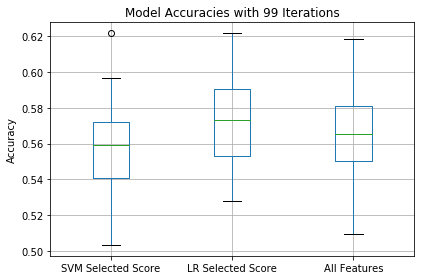

In [24]:
avg_classifier = svm.SVC()

model1_scores = []
model2_scores = []
model3_scores = []
    
for i in range(0,100):

    predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, test_size=0.2, shuffle=True, stratify=target)

    min_max_scaler.fit(predictors_train)
    predictors_train = min_max_scaler.transform(predictors_train)
    predictors_test = min_max_scaler.transform(predictors_test)

    predictors_train_SVMselected = selectorSVM.transform(predictors_train)
    predictors_test_SVMselected = selectorSVM.transform(predictors_test)
    predictors_train_LRselected = selectorLR.transform(predictors_train)
    predictors_test_LRselected = selectorLR.transform(predictors_test)

    model1 = avg_classifier.fit(predictors_train_SVMselected, target_train)
    model1_scores.append(model1.score(predictors_test_SVMselected, target_test))

    model2 = avg_classifier.fit(predictors_train_LRselected, target_train)
    model2_scores.append(model2.score(predictors_test_LRselected, target_test))

    model3 = avg_classifier.fit(predictors_train, target_train)
    model3_scores.append(model3.score(predictors_test, target_test))
    
scores_df = pd.DataFrame({
    'SVM Selected Score': model1_scores,
    'LR Selected Score' : model2_scores,
    'All Features' : model3_scores
})

scores_df.boxplot()
plt.title("Model Accuracies with {} Iterations".format(i))
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

### Conclusion

Linear Model seems to perform the best having the highest mean/average score.

This particulary proves that we dont need the full set of features in order to get a model which could predict with more or same accuracy as the model with all features.

# Task 3
  * Build two pipelines for training classifiers for the dataset winequality_red.csv and summarise the results from training classifiers with the pipelines in a markdown cell (max 150 words).
  * The two pipelines should include feature-selection methods, and the feature-selection method in pipeline 1 should be different from the feature-selection method in pipeline 2.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(predictors, target, test_size=0.20, shuffle=True, stratify=target)

pipeline1 = Pipeline([
    ('scaler',    preprocessing.MinMaxScaler()),
    ('feature_selection', SelectKBest(score_func=chi2, k=3)),
    ('classifier', LogisticRegression()),
])

pipeline2 = Pipeline([
    ('scaler',    preprocessing.MinMaxScaler()),
    ('feature_selection', RFE(ExtraTreesClassifier(), 3)),
    ('classifier', LogisticRegression()),
])

# Credit to Mark M for getting the results in the form of a dataframe
# for easy identification of features
clfs = {'SelectKBest':pipeline1,'RFE Tree':pipeline2}

columns=['KFold', 'Pipeline', 'Avg CV Score', 'Test Score','Validation Score','Feature 1','Feature 2','Feature 3']
pipeline_results = pd.DataFrame(columns=columns)

for i in range(5,11):
    k_fold = StratifiedKFold(n_splits=i, shuffle=True)
    for clf_name in clfs:
        clf = clfs[clf_name]
        results = cross_val_score(clf, X_train, y_train, cv=k_fold,n_jobs=-1)
        clf.fit(X_train, y_train)
        result_test = clf.score(X_train, y_train)
        result_val = clf.score(X_val, y_val)
        feat = list(np.where(clf.named_steps['feature_selection'].get_support()))
        pipeline_results = pipeline_results.append(pd.DataFrame([[i,clf_name,results.mean(),result_test,result_val,feat[0][0],feat[0][1],feat[0][2]]], columns=columns))

pipeline_results['Delta Score'] = np.abs(pipeline_results['Validation Score'] - pipeline_results['Avg CV Score'])




In [22]:
pipeline_results.sort_values(by=['Pipeline','Delta Score'])

,KFold,Pipeline,Avg CV Score,Test Score,Validation Score,Feature 1,Feature 2,Feature 3,Delta Score
0,7,RFE Tree,0.560681,0.562158,0.571875,1,6,10,0.011194
0,10,RFE Tree,0.554292,0.562158,0.571875,1,6,10,0.017583
0,5,RFE Tree,0.564640,0.563722,0.584375,6,9,10,0.019735
0,8,RFE Tree,0.562774,0.563722,0.584375,6,9,10,0.021601
0,6,RFE Tree,0.561420,0.563722,0.584375,6,9,10,0.022955
0,9,RFE Tree,0.555351,0.563722,0.584375,6,9,10,0.029024
0,9,SelectKBest,0.561436,0.562158,0.565625,1,2,10,0.004189
0,8,SelectKBest,0.560584,0.562158,0.565625,1,2,10,0.005041
0,6,SelectKBest,0.556736,0.562158,0.565625,1,2,10,0.008889
0,7,SelectKBest,0.555039,0.562158,0.565625,1,2,10,0.010586


In [23]:
for i in [1, 6,9,10]:
    print ("{} = {} ".format(i,number_columns[i]))

1 = volatile acidity 
6 = total sulfur dioxide 
9 = sulphates 
10 = alcohol 


**Conclusion**
- The training score i.e. the insample score is comparable across both the feature selection methods.
- We can see that the model generated using RFE feature selection outperforms the one where SelectKBest is used as far as the validation score i.e. the Eout is concerned.
- Both the feature selection methods select a different set of features 
- This shows that the features computed by RFE are more representative of the data set than the features selected by SelectKBest.